In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE

In [4]:
data = pd.read_excel('./default of credit card clients.xls', header=1, index_col=0)

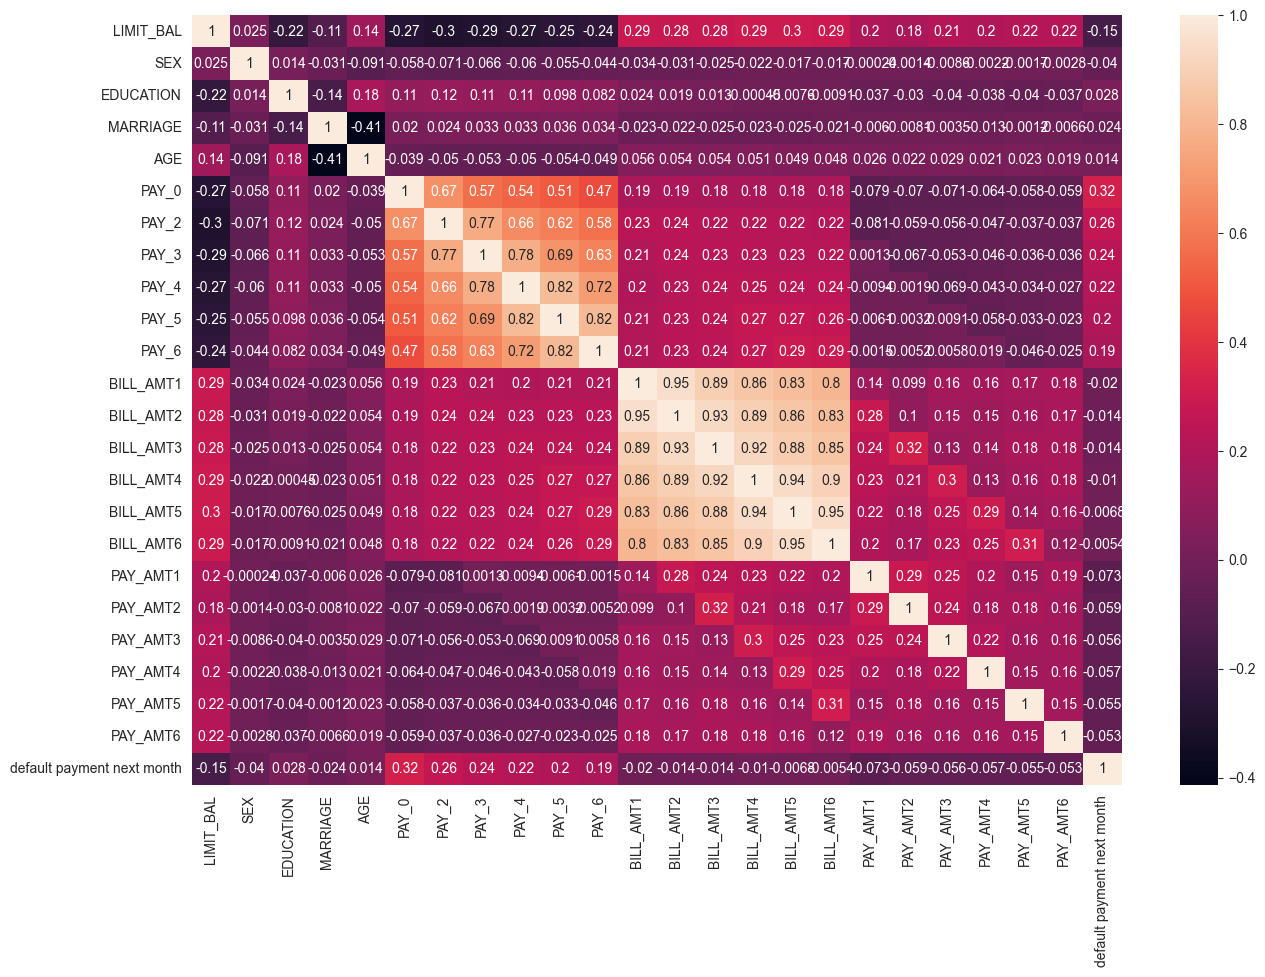

In [5]:
plt.subplots(figsize=(15,10))
sns.heatmap(data.corr(), annot=True)
plt.show()

C:\Users\ice1s\AppData\Local\Temp\ipykernel_10020\3819007558.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(summary_stats_transposed.index, rotation=90)
C:\Users\ice1s\AppData\Local\Temp\ipykernel_10020\3819007558.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(summary_stats_transposed.index, rotation=90)


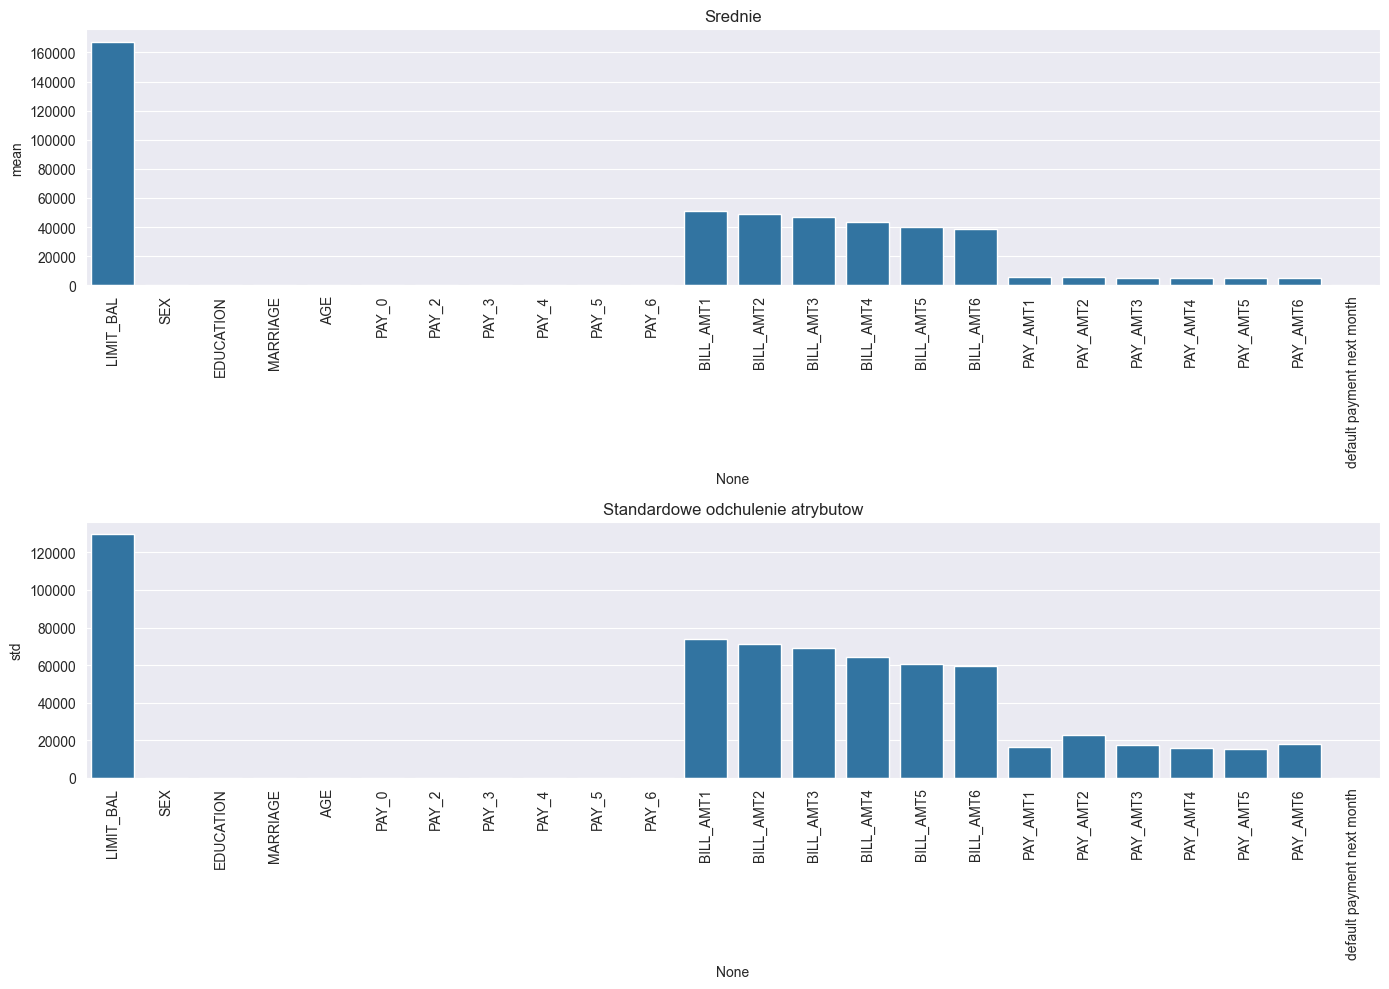

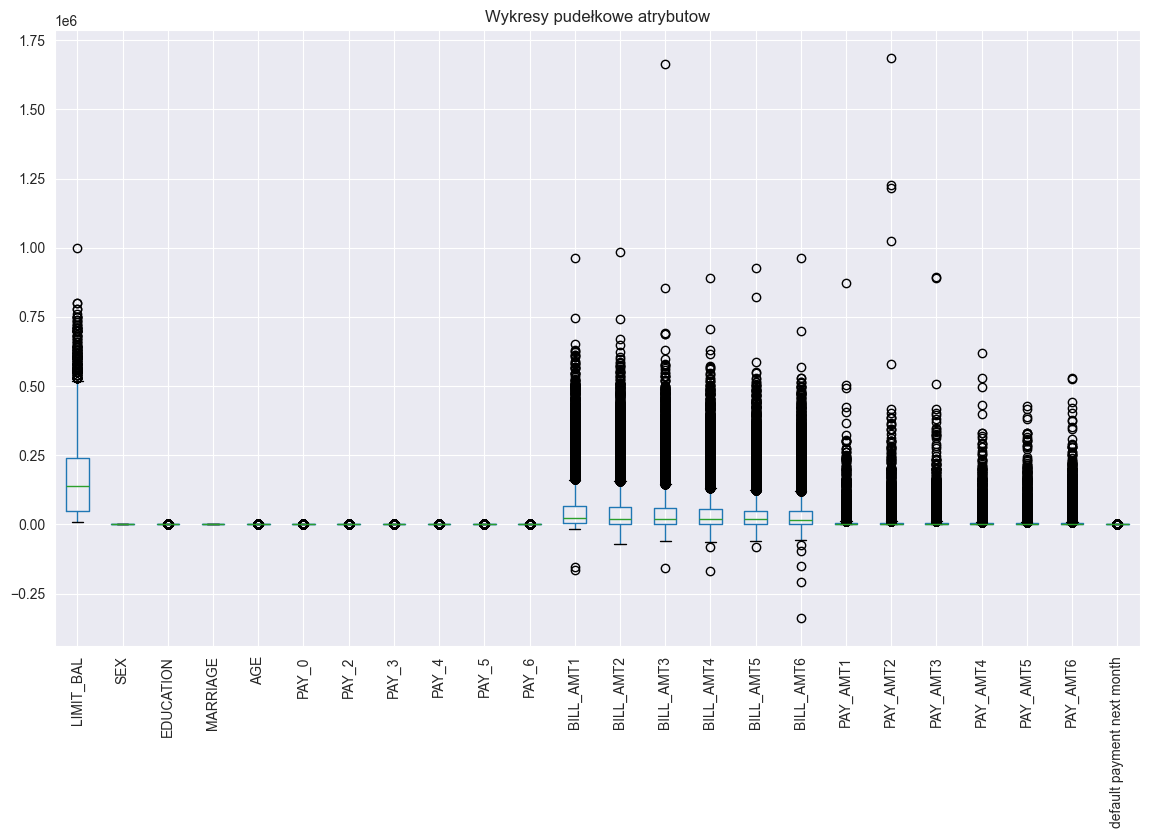

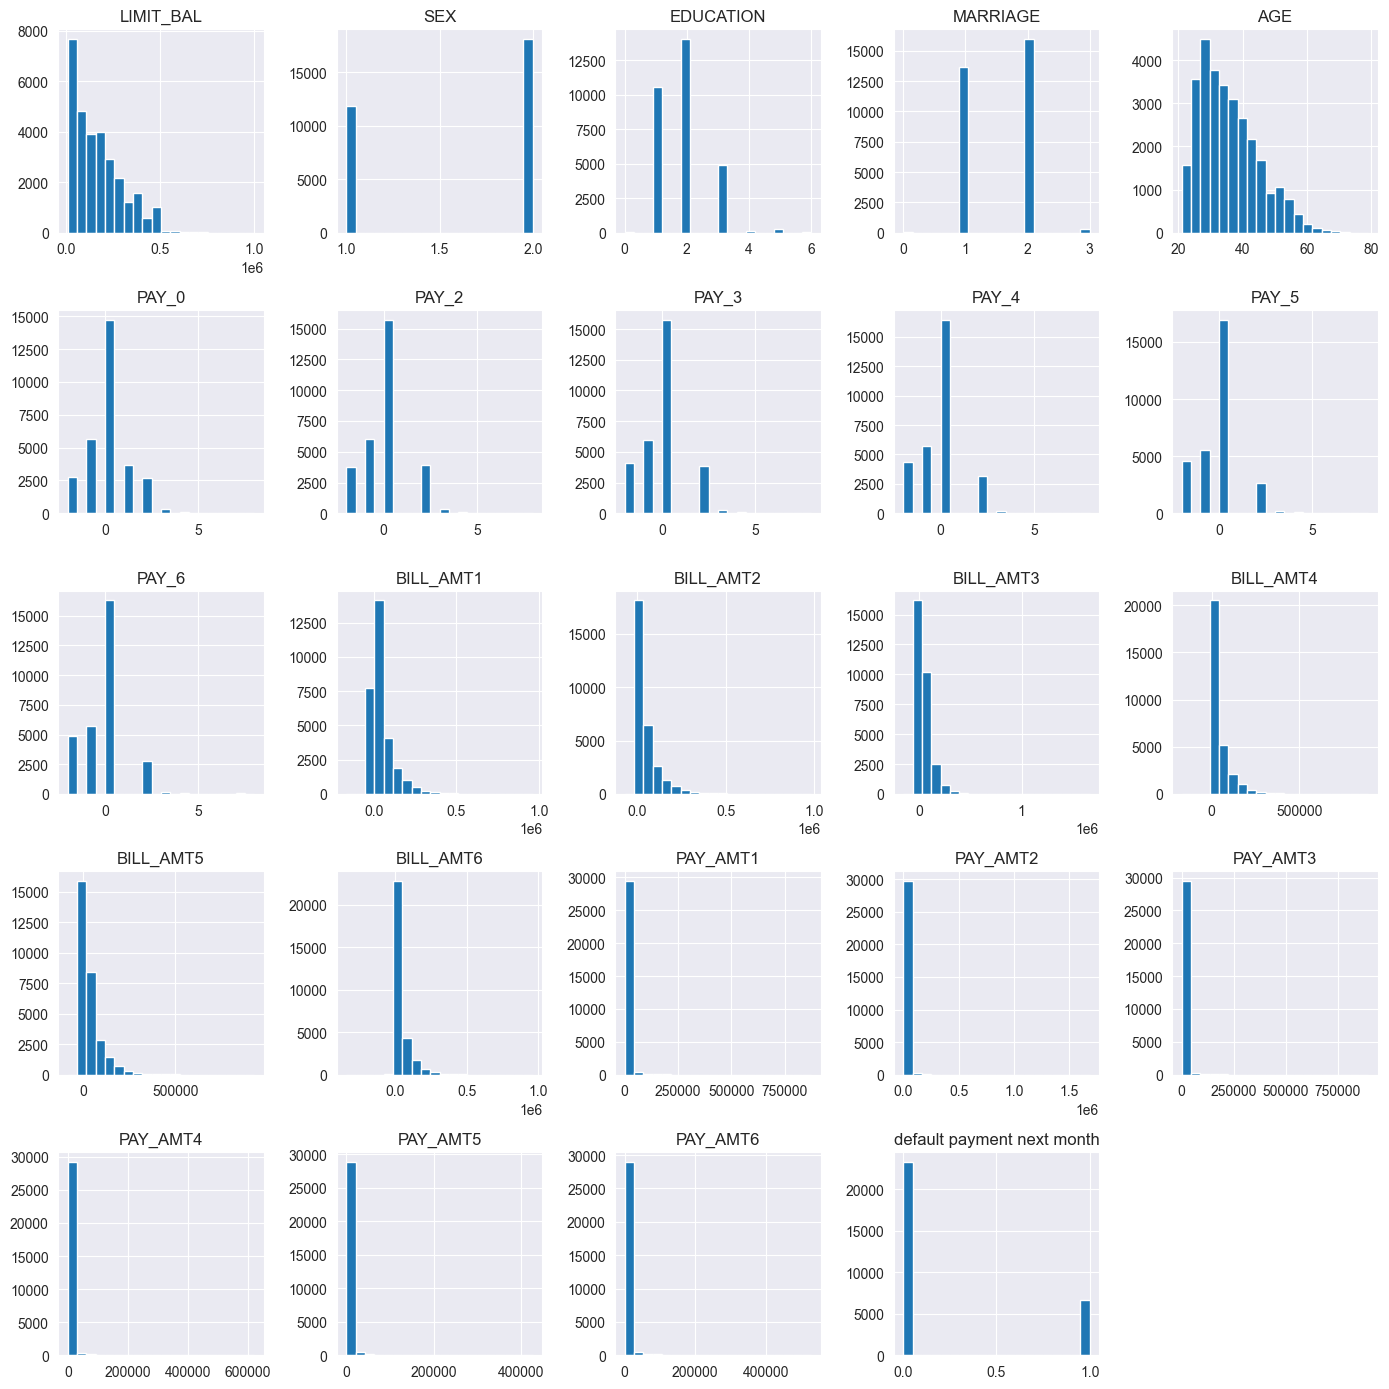

In [8]:
summary_stats = data.describe()

def plot_boxplots(df):
    plt.figure(figsize=(14, 8))
    df.boxplot(rot=90)
    plt.title('Wykresy pudełkowe atrybutow')
    plt.show()


def plot_summary_statistics(summary_stats):
    summary_stats_transposed = summary_stats.T
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))

    # Bar plot for mean
    sns.barplot(x=summary_stats_transposed.index, y='mean', data=summary_stats_transposed, ax=axes[0])
    axes[0].set_title('Srednie')
    axes[0].set_xticklabels(summary_stats_transposed.index, rotation=90)

    # Bar plot for std
    sns.barplot(x=summary_stats_transposed.index, y='std', data=summary_stats_transposed, ax=axes[1])
    axes[1].set_title('Standardowe odchulenie atrybutow')
    axes[1].set_xticklabels(summary_stats_transposed.index, rotation=90)

    plt.tight_layout()
    plt.show()

def plot_histograms(df):
    df.hist(figsize=(14, 14), bins=20, layout=(5, 5))
    plt.tight_layout()
    plt.show()


plot_summary_statistics(summary_stats)
plot_boxplots(data)
plot_histograms(data)


In [16]:
def train_and_evaluate(X_train, y_train, X_test, y_test):
    results = {}

    # Logistic Regression
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    lr_accuracy = accuracy_score(y_test, y_pred_lr)
    lr_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
    results['Logistic Regression'] = {'Accuracy': lr_accuracy, 'AUC': lr_auc, 'Model': lr}

    # XGBoost
    xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
    xgb_auc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])
    results['XGBoost'] = {'Accuracy': xgb_accuracy, 'AUC': xgb_auc, 'Model': xgb}

    return results

def plot_results(results, title):
    df = pd.DataFrame(results).T.drop(columns='Model')
    df.plot(kind='bar', figsize=(12, 8))
    plt.title(title)
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.show()

def plot_lr_feature_importance(model, feature_names):
    importance = np.abs(model.coef_[0])
    feature_importance = pd.Series(importance, index=feature_names).sort_values(ascending=False)
    feature_importance.plot(kind='bar', figsize=(12, 8))
    plt.title('Logistic Regression Feature Importance')
    plt.ylabel('Importance')
    plt.show()
    return feature_importance

# Feature importance for XGBoost
def plot_xgb_feature_importance(model, feature_names):
    plt.figure(figsize=(12, 8))
    plot_importance(model, max_num_features=20, importance_type='weight')
    plt.title('XGBoost Feature Importance')
    plt.show()
    importance = model.get_booster().get_score(importance_type='weight')
    importance_mapped = {feature_names[int(k[1:])]: v for k, v in importance.items()}
    return importance_mapped

In [17]:
important_features = [
    'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5'
]

X = data[important_features]
y = data['default payment next month']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Balance the dataset
ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
smote = SMOTE(random_state=42)

X_ros, y_ros = ros.fit_resample(X_train, y_train)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

Original Data Results LR Accuracy: 0.8085555555555556
Original Data Results LR AUC: 0.7148939022863551
Original Data Results XGBoost Accuracy: 0.8097777777777778
Original Data Results XGBoost AUC: 0.7578297659771439
Oversampled Data Results LR Accuracy: 0.6835555555555556
Oversampled Data Results LR AUC: 0.7154790006305303
Oversampled Data Results XGBoost Accuracy: 0.7605555555555555
Oversampled Data Results XGBoost AUC: 0.7570249959888695
Undersampled Data Results LR Accuracy: 0.6806666666666666
Undersampled Data Results LR AUC: 0.7165695121555347
Undersampled Data Results XGBoost Accuracy: 0.7053333333333334
Undersampled Data Results XGBoost AUC: 0.7521754515379129
SMOTE Data Results LR Accuracy: 0.6713333333333333
SMOTE Data Results LR AUC: 0.7175828465933769
SMOTE Data Results XGBoost Accuracy: 0.8057777777777778
SMOTE Data Results XGBoost AUC: 0.7556773349956384


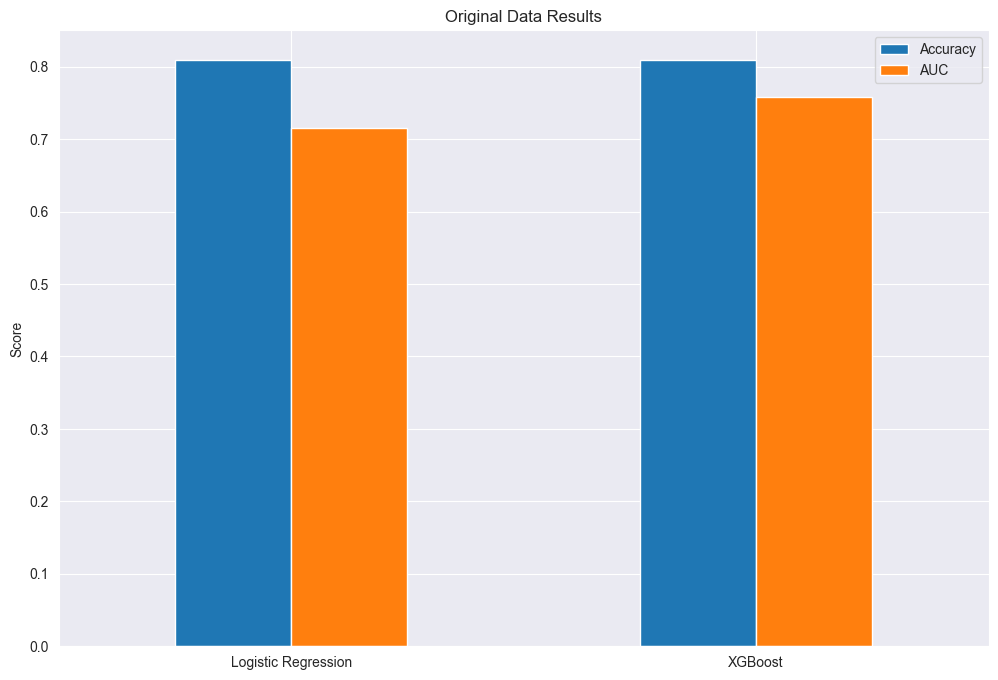

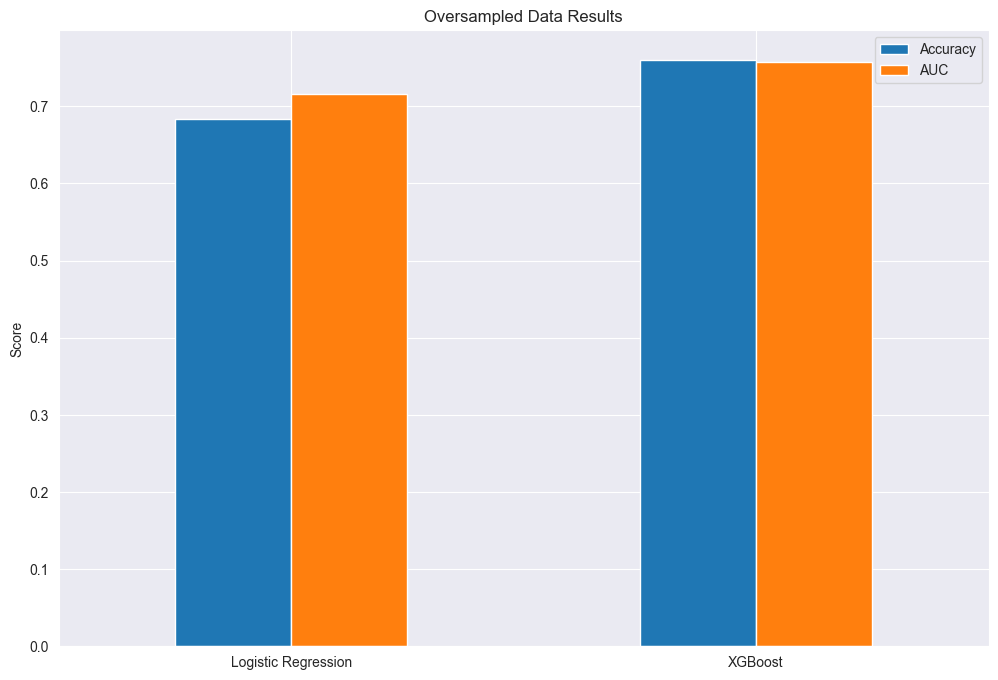

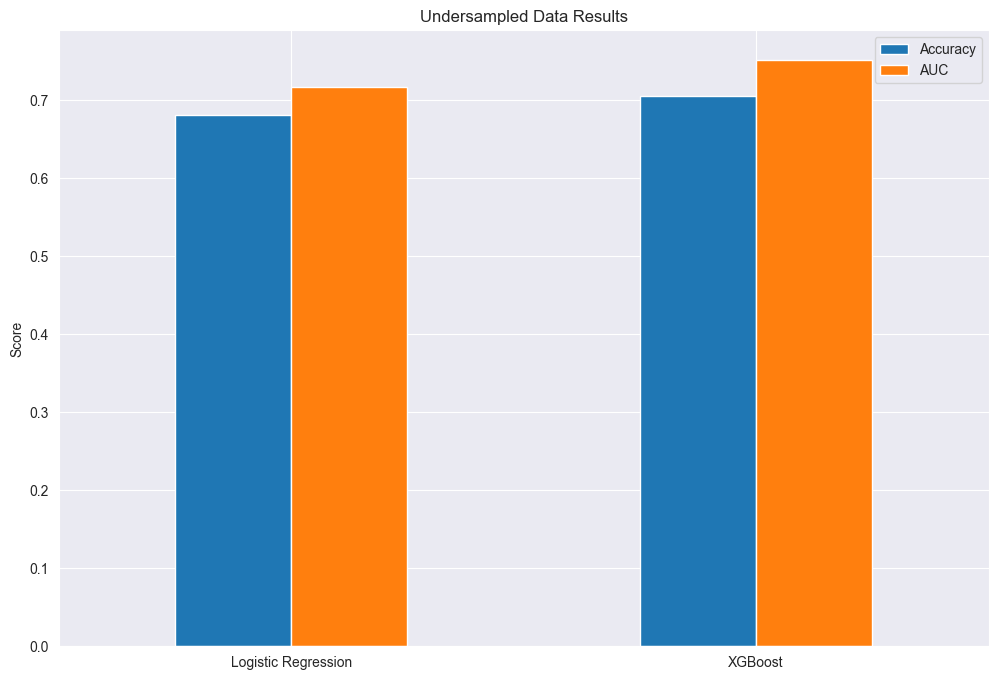

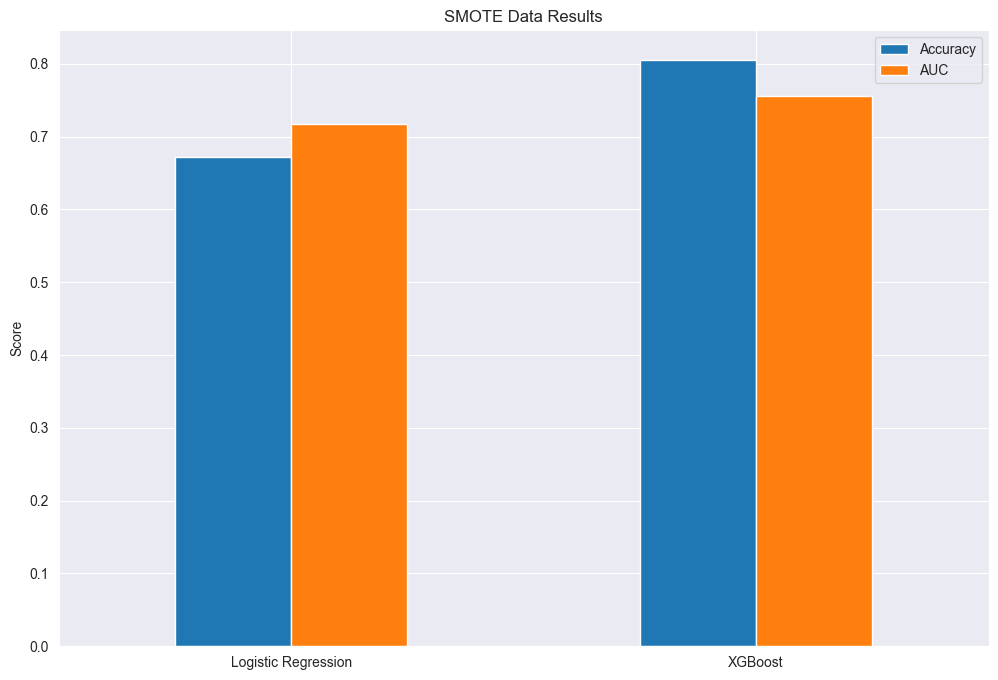

In [18]:
original_results = train_and_evaluate(X_train, y_train, X_test, y_test)
ros_results = train_and_evaluate(X_ros, y_ros, X_test, y_test)
rus_results = train_and_evaluate(X_rus, y_rus, X_test, y_test)
smote_results = train_and_evaluate(X_smote, y_smote, X_test, y_test)

print("Original Data Results LR Accuracy:", original_results['Logistic Regression']['Accuracy'])
print("Original Data Results LR AUC:", original_results['Logistic Regression']['AUC'])
print("Original Data Results XGBoost Accuracy:", original_results['XGBoost']['Accuracy'])
print("Original Data Results XGBoost AUC:", original_results['XGBoost']['AUC'])

print("Oversampled Data Results LR Accuracy:", ros_results['Logistic Regression']['Accuracy'])
print("Oversampled Data Results LR AUC:", ros_results['Logistic Regression']['AUC'])
print("Oversampled Data Results XGBoost Accuracy:", ros_results['XGBoost']['Accuracy'])
print("Oversampled Data Results XGBoost AUC:", ros_results['XGBoost']['AUC'])

print("Undersampled Data Results LR Accuracy:", rus_results['Logistic Regression']['Accuracy'])
print("Undersampled Data Results LR AUC:", rus_results['Logistic Regression']['AUC'])
print("Undersampled Data Results XGBoost Accuracy:", rus_results['XGBoost']['Accuracy'])
print("Undersampled Data Results XGBoost AUC:", rus_results['XGBoost']['AUC'])

print("SMOTE Data Results LR Accuracy:", smote_results['Logistic Regression']['Accuracy'])
print("SMOTE Data Results LR AUC:", smote_results['Logistic Regression']['AUC'])
print("SMOTE Data Results XGBoost Accuracy:", smote_results['XGBoost']['Accuracy'])
print("SMOTE Data Results XGBoost AUC:", smote_results['XGBoost']['AUC'])

plot_results(original_results, 'Original Data Results')
plot_results(ros_results, 'Oversampled Data Results')
plot_results(rus_results, 'Undersampled Data Results')
plot_results(smote_results, 'SMOTE Data Results')


Logistic Regression Feature Importance (Original Data):


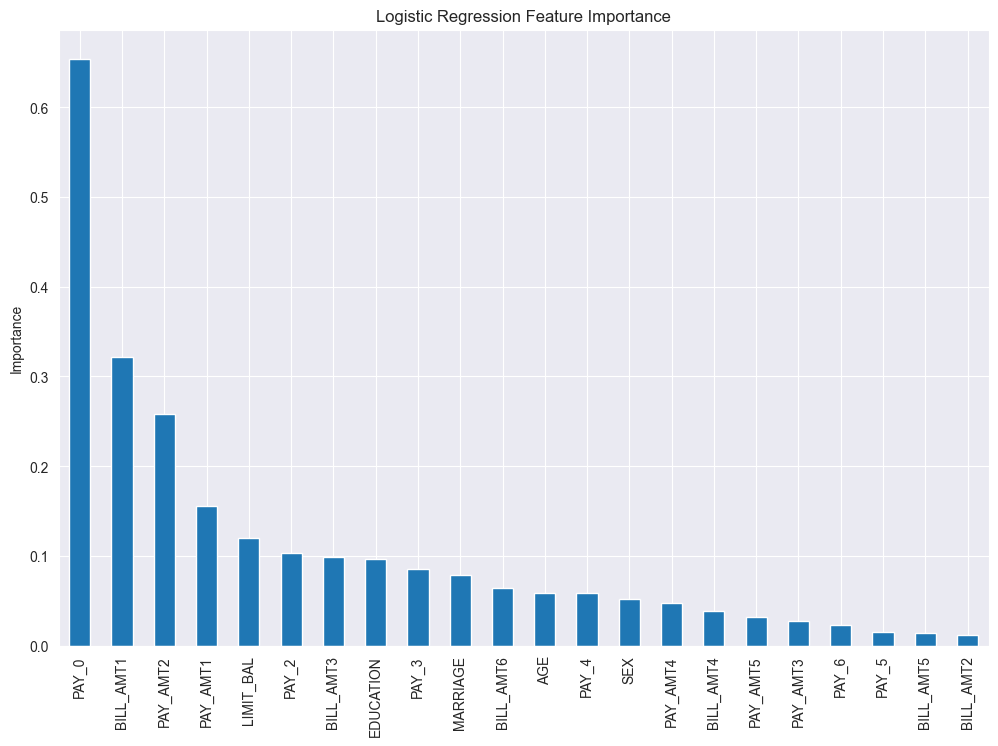


XGBoost Feature Importance (Original Data):


<Figure size 1200x800 with 0 Axes>

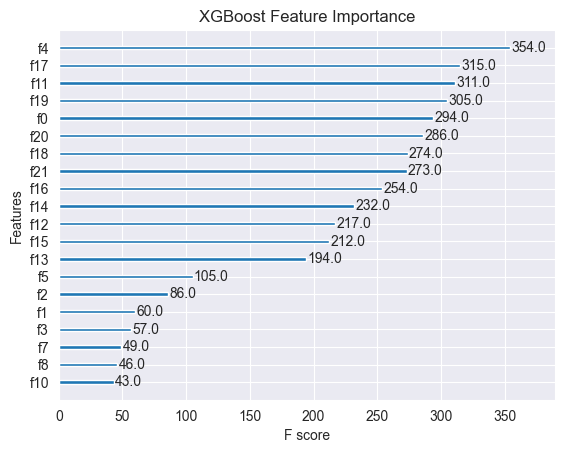

In [19]:
print("\nLogistic Regression Feature Importance (Original Data):")
lr_feature_importance = plot_lr_feature_importance(original_results['Logistic Regression']['Model'], important_features)

print("\nXGBoost Feature Importance (Original Data):")
xgb_feature_importance = plot_xgb_feature_importance(original_results['XGBoost']['Model'], important_features)

In [20]:
selected_features_lr = lr_feature_importance[lr_feature_importance > 0.1].index.tolist()
selected_features_xgb = [key for key, value in xgb_feature_importance.items() if value > 200]

print(f"\nSelected Features for Logistic Regression: {selected_features_lr}")
print(f"Selected Features for XGBoost: {selected_features_xgb}")


Selected Features for Logistic Regression: ['PAY_0', 'BILL_AMT1', 'PAY_AMT2', 'PAY_AMT1', 'LIMIT_BAL', 'PAY_2']
Selected Features for XGBoost: ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5']


In [21]:
X_train_lr = pd.DataFrame(X_train, columns=important_features)[selected_features_lr]
X_test_lr = pd.DataFrame(X_test, columns=important_features)[selected_features_lr]

X_train_xgb = pd.DataFrame(X_train, columns=important_features)[selected_features_xgb]
X_test_xgb = pd.DataFrame(X_test, columns=important_features)[selected_features_xgb]

# Retrain and evaluate logistic regression
lr_retrained = LogisticRegression(random_state=42)
lr_retrained.fit(X_train_lr, y_train)
y_pred_lr_retrained = lr_retrained.predict(X_test_lr)
lr_accuracy_retrained = accuracy_score(y_test, y_pred_lr_retrained)
lr_auc_retrained = roc_auc_score(y_test, lr_retrained.predict_proba(X_test_lr)[:, 1])

# Retrain and evaluate XGBoost
xgb_retrained = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_retrained.fit(X_train_xgb, y_train)
y_pred_xgb_retrained = xgb_retrained.predict(X_test_xgb)
xgb_accuracy_retrained = accuracy_score(y_test, y_pred_xgb_retrained)
xgb_auc_retrained = roc_auc_score(y_test, xgb_retrained.predict_proba(X_test_xgb)[:, 1])

# Print the retrained results
print("\nRetrained Logistic Regression Results:")
print(f"Accuracy: {lr_accuracy_retrained}, AUC: {lr_auc_retrained}")

print("\nRetrained XGBoost Results:")
print(f"Accuracy: {xgb_accuracy_retrained}, AUC: {xgb_auc_retrained}")


Retrained Logistic Regression Results:
Accuracy: 0.8078888888888889, AUC: 0.7119999048364236

Retrained XGBoost Results:
Accuracy: 0.7831111111111111, AUC: 0.71320625365149


In [22]:
#Recursive Feature Elimination (RFE)
rfe = RFE(estimator=original_results['Logistic Regression']['Model'], n_features_to_select=10)
rfe.fit(X, y)

selected_features_rfe = X.columns[rfe.support_]
print("Selected features using RFE: ", selected_features_rfe)

Selected features using RFE:  Index(['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3',
       'PAY_4', 'PAY_5', 'PAY_6'],
      dtype='object')


In [23]:
from sklearn.feature_selection import SequentialFeatureSelector

#Sequential Feature Selection (SFS)
sfs = SequentialFeatureSelector(original_results['Logistic Regression']['Model'], n_features_to_select=10, direction='forward')
sfs.fit(X, y)

selected_features_sfs = X.columns[sfs.get_support()]
print("Selected features using SFS: ", selected_features_sfs)

Selected features using SFS:  Index(['SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5'],
      dtype='object')


In [26]:
X_train_rfe = pd.DataFrame(X_train, columns=important_features)[selected_features_rfe]
X_test_rfe = pd.DataFrame(X_test, columns=important_features)[selected_features_rfe]

# Retrain and evaluate logistic regression
lr_retrained = LogisticRegression(random_state=42)
lr_retrained.fit(X_train_rfe, y_train)
y_pred_lr_retrained = lr_retrained.predict(X_test_rfe)
lr_accuracy_retrained = accuracy_score(y_test, y_pred_lr_retrained)
lr_auc_retrained = roc_auc_score(y_test, lr_retrained.predict_proba(X_test_rfe)[:, 1])

# Retrain and evaluate XGBoost
xgb_retrained = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_retrained.fit(X_train_rfe, y_train)
y_pred_xgb_retrained = xgb_retrained.predict(X_test_rfe)
xgb_accuracy_retrained = accuracy_score(y_test, y_pred_xgb_retrained)
xgb_auc_retrained = roc_auc_score(y_test, xgb_retrained.predict_proba(X_test_rfe)[:, 1])

# Print the retrained results
print("\nRetrained Logistic Regression Results RFE:")
print(f"Accuracy: {lr_accuracy_retrained}, AUC: {lr_auc_retrained}")

print("\nRetrained XGBoost Results RFE:")
print(f"Accuracy: {xgb_accuracy_retrained}, AUC: {xgb_auc_retrained}")


Retrained Logistic Regression Results RFE:
Accuracy: 0.8086666666666666, AUC: 0.6975490506250878

Retrained XGBoost Results RFE:
Accuracy: 0.814, AUC: 0.7388514401265962


In [27]:
X_train_sfs = pd.DataFrame(X_train, columns=important_features)[selected_features_sfs]
X_test_sfs = pd.DataFrame(X_test, columns=important_features)[selected_features_sfs]

# Retrain and evaluate logistic regression
lr_retrained = LogisticRegression(random_state=42)
lr_retrained.fit(X_train_sfs, y_train)
y_pred_lr_retrained = lr_retrained.predict(X_test_sfs)
lr_accuracy_retrained = accuracy_score(y_test, y_pred_lr_retrained)
lr_auc_retrained = roc_auc_score(y_test, lr_retrained.predict_proba(X_test_sfs)[:, 1])

# Retrain and evaluate XGBoost
xgb_retrained = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_retrained.fit(X_train_sfs, y_train)
y_pred_xgb_retrained = xgb_retrained.predict(X_test_sfs)
xgb_accuracy_retrained = accuracy_score(y_test, y_pred_xgb_retrained)
xgb_auc_retrained = roc_auc_score(y_test, xgb_retrained.predict_proba(X_test_sfs)[:, 1])

# Print the retrained results
print("\nRetrained Logistic Regression Results SFS:")
print(f"Accuracy: {lr_accuracy_retrained}, AUC: {lr_auc_retrained}")

print("\nRetrained XGBoost Results SFS:")
print(f"Accuracy: {xgb_accuracy_retrained}, AUC: {xgb_auc_retrained}")


Retrained Logistic Regression Results SFS:
Accuracy: 0.8117777777777778, AUC: 0.7061862559001597

Retrained XGBoost Results SFS:
Accuracy: 0.8127777777777778, AUC: 0.7428804853686359
